## Single-word speech recognition on the Tensorflow Speech Recognition dataset

This notebook has four sections: preprocessing, training, evaluation, and testing on own voice commands. To evaluate the final result, skip to section 4 (testing on own voice commands).


In [2]:
import os
import random
import time

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

import librosa
import IPython.display as ipd
from scipy.io import wavfile

### 1. Preprocess dataset

This step relies on previous preprocessing that simply cropped the first second of each audio file and saved the recordings as rows in one big matrix (ndarray).

In [3]:
labels = np.load("data/labels.npy")
labels

array(['bed', 'bird', 'cat', 'dog', 'down', 'eight', 'five', 'four', 'go',
       'happy', 'house', 'left', 'marvin', 'nine', 'no', 'off', 'on',
       'one', 'right', 'seven', 'sheila', 'six', 'stop', 'three', 'tree',
       'two', 'up', 'wow', 'yes', 'zero'], dtype='<U6')

In [ ]:
sr = 8000

In [2]:
x_train_raw = np.load("data/raw/x_train.npy")

In [6]:
n_examples, rec_length = x_train_raw.shape

In [11]:
first_example = x_train_raw[0]
print(labels[y_train_raw[0]])
ipd.Audio(first_example, rate=8000)

seven


Prepare Mel spectrograms for the recordings in the dataset

In [18]:
first_mel = librosa.feature.melspectrogram(first_example)
first_mel = first_mel.T  # transpose for LSTM
n_tsteps, n_mels = first_mel.shape

In [23]:
x_train = np.zeros(shape=(n_examples, n_tsteps, n_mels, 1))

for i in range(n_examples):
    # extract audio recording
    rec = x_train_raw[i]
    
    # convert to Mel spectrogram (transposed for LSTM compatibility)
    melspec = librosa.feature.melspectrogram(rec).T
    
    x_train[i, :, :, 0] = melspec
    
    print("\rDone %d/%d." % (i+1, n_examples), end='')
    
# save data to disk
np.save("data/mel/x_train", x_train)

Done 56721/56721.

In [31]:
# do the same for validation set
x_val_raw = np.load("data/raw/x_val.npy")
n_examples, rec_length = x_val_raw.shape

x_val = np.zeros(shape=(n_examples, n_tsteps, n_mels, 1))

for i in range(n_examples):
    # extract audio recording
    rec = x_val_raw[i]
    
    # convert to Mel spectrogram (transposed for LSTM compatibility)
    melspec = librosa.feature.melspectrogram(rec).T
    
    x_val[i, :, :, 0] = melspec
    
    print("\rDone %d/%d." % (i+1, n_examples), end='')
    
# save data to disk
np.save("data/mel/x_val", x_val)

Done 1000/1000.

In [33]:
# do the same for test set
x_test_raw = np.load("data/raw/x_test.npy")
n_examples, rec_length = x_test_raw.shape

x_test = np.zeros(shape=(n_examples, n_tsteps, n_mels, 1))

for i in range(n_examples):
    # extract audio recording
    rec = x_test_raw[i]
    
    # convert to Mel spectrogram (transposed for LSTM compatibility)
    melspec = librosa.feature.melspectrogram(rec).T
    
    x_test[i, :, :, 0] = melspec
    
    print("\rDone %d/%d." % (i+1, n_examples), end='')
    
# save data to disk
np.save("data/mel/x_test", x_test)

Done 7000/7000.

### 2. Train on dataset

In [6]:
from tensorflow.keras.models import Sequential, Model, model_from_json
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dense, LSTM, Embedding, BatchNormalization, Reshape, Activation, Dropout
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.optimizers import Adam

In [7]:
y_train = np.load("data/raw/y_train.npy")
y_val = np.load("data/raw/y_val.npy")

In [8]:
# define CNN LSTM for speech command recognition
def lstm_speech(input_shape):
    model = Sequential()
    model.add(Conv2D(input_shape=input_shape, filters=16, kernel_size=(3,5), padding='valid', activation='relu'))
    model.add(MaxPooling2D(pool_size=(1, 2), strides=(1, 2)))
    model.add(BatchNormalization())

    model.add(Conv2D(filters=16, kernel_size=(3,5), padding='valid', activation='relu'))
    model.add(MaxPooling2D(pool_size=(1, 2), strides=(1, 2)))
    model.add(BatchNormalization())

    model.add(Conv2D(filters=32, kernel_size=(3,5), padding='valid', activation='relu'))
    model.add(MaxPooling2D(pool_size=(1, 2), strides=(1, 2)))
    model.add(BatchNormalization())

    model.add(Conv2D(filters=64, kernel_size=(3,5), padding='valid', activation='relu'))
    model.add(MaxPooling2D(pool_size=(1, 2), strides=(1, 2)))
    model.add(Dropout(rate=0.3))

    model.add(Reshape((8, 4*64)))

    model.add(LSTM(100, input_shape=(16, 112*16)))
    model.add(Dense(30, activation='softmax'))

    return model

In [9]:
def savemodel(model, name, model_path='model/'):
    """
    Convenience method that makes it easy to save a model
    """

    model_json = model.to_json()
    with open(model_path + name + ".json", "w") as json_file:
        json_file.write(model_json)
    # serialize weights to HDF5
    model.save_weights(model_path + name + ".h5")
    print("Saved model to disk")

In [2]:
def loadmodel(name, model_path='model/'):
    """
    Convenience method that makes it easy to load a model
    """

    json_file = open(model_path + name + ".json", 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    model = model_from_json(loaded_model_json)
    # load weights into new model
    model.load_weights(model_path + name + ".h5")
    print("Loaded model %s from disk" % name)

    return model

In [38]:
model = lstm_speech(x_val[0].shape)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 14, 124, 16)       256       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 62, 16)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 14, 62, 16)        64        
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 12, 58, 16)        3856      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 29, 16)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 12, 29, 16)        64        
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 10, 25, 32)        7

In [43]:
model.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history = model.fit(x=x_train, y=y_train, batch_size=256, epochs=30, validation_data=(x_val, y_val))
savemodel(model, "speech_class")

Epoch 1/30
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
222/222 [==============================] - ETA: 0s - loss: 2.2953 - accuracy: 0.3124WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x2ae1368c8> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the 

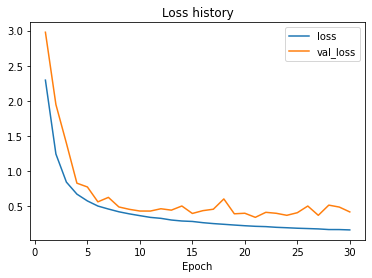

In [44]:
plt.plot(np.arange(1, len(history.history["loss"])+1), history.history["loss"], label="loss")
plt.plot(np.arange(1, len(history.history["loss"])+1), history.history["val_loss"], label="val_loss")
plt.legend()
plt.xlabel("Epoch")
plt.title("Loss history")
plt.show()

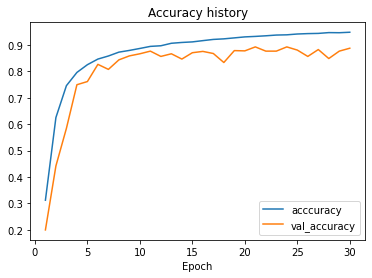

In [45]:
plt.plot(np.arange(1, len(history.history["accuracy"])+1), history.history["accuracy"], label="acccuracy")
plt.plot(np.arange(1, len(history.history["accuracy"])+1), history.history["val_accuracy"], label="val_accuracy")
plt.legend()
plt.xlabel("Epoch")
plt.title("Accuracy history")
plt.show()

### 3. Evaluate model

In [27]:
x_test = np.load("data/mel/x_test.npy")
y_test = np.load("data/raw/y_test.npy")

In [28]:
model = loadmodel("speech_class")
model.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

Loaded model speech_class from disk


In [12]:
test_acc = model.evaluate(x=x_test, y=y_test)[1]
print("Testing accuracy: %.3f." % test_acc)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
219/219 [==============================] - 4s 17ms/step - loss: 0.3545 - accuracy: 0.8963
Testing accuracy: 0.896.


### 4. Test own voice commands

This section handles loading the model, recording a short voice clip, and using the model to classify the uttered word.

In [172]:
import os
import random
import time
import logging

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

import librosa
import IPython.display as ipd
from scipy.io import wavfile 

from tensorflow.keras.models import Sequential, Model, model_from_json
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dense, LSTM, Embedding, BatchNormalization, Reshape, Activation, Dropout
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.optimizers import Adam


# load and compile model
model_path = "model/"
name = "speech_class"

json_file = open(model_path + name + ".json", 'r')
loaded_model_json = json_file.read()
json_file.close()
model = model_from_json(loaded_model_json)
model.load_weights(model_path + name + ".h5")
print("Loaded model %s from disk" % name)
model.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

Loaded model speech_class from disk


In [173]:
def record(name, sr=8000):
    """
    helper function that records and returns a 2-second voice clip
    
    name: (str) filename for recording
    sr: (int) sample rate
    
    return: tuple: (ndarray) audio recording, (int) sample rate
    """
    
    if name.endswith(".wav"):
        name = name[:-4]
    
    # make temporary recording on hard disk
    os.system("sox -b 32 -e unsigned-integer -r 44100 -c 2 -d --clobber --buffer $((96000*2*10)) %s.wav trim 0 2" % 
              name)
    
    # load samples into local variable
    rec, sr = librosa.load(name + ".wav", sr=sr)
    
    # normalize recording
    rec /= np.amax(np.abs(rec))
    
    # erase temporary recording from hard disk and return the samples loaded into local variable
    os.unlink(name + ".wav")
    return rec, sr

In [174]:
def trim(x, target_length=1, sr=8000, hop_length=100):
    """
    helper function that trims audio clip x to target_length around the onset of the uttered word
    
    x: (ndarray) audio clip
    target_length: (float) desired length in seconds
    sr: (int) sample rate
    hop_length: (int) frame hop length for onset_detect
    
    return:
    clip: (ndarray) trimmed recording
    """
    
    # convert from seconds to samples
    target_length = int(target_length*sr)
    
    if len(x) < target_length:
        raise RuntimeError("Error in trim: target length %.2f greater than recording length %.2f." % 
                           (target_length/sr, len(x)/sr))
    
    # find onsets and use first one as reference for trimming clip
    onset_samples = librosa.onset.onset_detect(rec,
                                           sr=sr, units='samples', 
                                           hop_length=hop_length, 
                                           backtrack=False,
                                           pre_max=20,
                                           post_max=20,
                                           pre_avg=100,
                                           post_avg=100,
                                           delta=0.2,
                                           wait=0)
    
    # start click sligthly before onset; if onset too early, start at the beginning
    starting_idx = onset_samples[0] - target_length//5
    if starting_idx < 0:
        starting_idx = 0
    
    # if onset too late, just use the last (target_samples) samples
    if len(x)-starting_idx < target_length:
        starting_idx = len(x)-target_length-1
    
    return x[starting_idx:starting_idx+target_length]

*__Note__: make sure the recorded word is one of the 30 words the network has learned.*

In [175]:
# load the labels the network was trained on
labels = np.load("data/labels.npy")
labels

array(['bed', 'bird', 'cat', 'dog', 'down', 'eight', 'five', 'four', 'go',
       'happy', 'house', 'left', 'marvin', 'nine', 'no', 'off', 'on',
       'one', 'right', 'seven', 'sheila', 'six', 'stop', 'three', 'tree',
       'two', 'up', 'wow', 'yes', 'zero'], dtype='<U6')

In [180]:
# record a 2-second clip, trim it to one second, and predict uttered word
rec, sr = record("test")
clip = trim(rec)

# take the Mel spectrogramm of the voice clip and reshape for the network
clip_mel = librosa.feature.melspectrogram(clip).T
clip_mel = np.expand_dims(clip_mel, axis=[0, -1])

# use the network to predict the uttered word
print("\nThe uttered word is: %s." % labels[np.argmax(model.predict(clip_mel))])

ipd.Audio(clip, rate=sr)


The uttered word is: wow.
